<a href="https://colab.research.google.com/github/ybressler/broadway_scraping/blob/master/Modelling/Neural_Networks_on_Broadway_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of this project

# Section 1

In [0]:
import pandas as pd

def max_string(arr):
  """
  gets you the max length string
  """
  max_l = 0
  max_string =None
  for x in arr:
    if len(str(x))>max_l:
      max_l = len(str(x))
      max_string = str(x)
  return max_string

In [0]:
best_musical = 'https://github.com/ybressler/broadway_scraping/blob/master/Wikipedia_scrape_Tony_Award_for_Best_Musical.csv'
best_rev_musical = 'https://github.com/ybressler/broadway_scraping/blob/master/Wikipedia_scrape_Tony_Award_for_Best_Revival_of_a_Musical.csv'

In [0]:
df_musical = pd.read_html(best_musical)[0]
# drop unnecessary columns
df_musical.drop(columns=[x for x in df_musical.columns if 'Unnamed' in x], inplace=True)
df_musical['Revival'] = False

df_rev_musical = pd.read_html(best_rev_musical)[0]
# drop unnecessary columns
df_rev_musical.drop(columns=[x for x in df_rev_musical.columns if 'Unnamed' in x], inplace=True)
df_rev_musical['Revival'] = True

In [0]:
df_rev_musical.tail()

,Year,Winner,Musical,Music,Book,Lyrics,Link,Revival
84,2018,True,Once on This Island,Stephen Flaherty,Lynn Ahrens,Ahrens,https://en.wikipedia.org/wiki/Once_on_This_Island,True
85,2018,False,Carousel,Richard Rodgers,Oscar Hammerstein II,Hammerstein,https://en.wikipedia.org/wiki/Carousel_(musical),True
86,2018,False,My Fair Lady,Frederick Loewe,Alan Jay Lerner,Lerner,https://en.wikipedia.org/wiki/My_Fair_Lady,True
87,2019,True,Oklahoma!,Richard Rodgers,Oscar Hammerstein II,Hammerstein,https://en.wikipedia.org/wiki/Oklahoma!,True
88,2019,False,"Kiss Me, Kate",Cole Porter,Bella & Samuel Spewack,Cole Porter,"https://en.wikipedia.org/wiki/Kiss_Me,_Kate",True


In [0]:
name_mapper = {
    'Oscar Hammerstein II': 'Oscar Hammerstein',
}

# Do it once
records = []
for idx, row in df_rev_musical.iterrows():
  yr, win, musical = row[['Year','Winner','Musical']]
  for role in ['Music','Book','Lyrics']:
    name = row[role]

    name_list = name.split('&') if '&' in name else name.split(',') if ',' in name else [name]
    for n in name_list:
      n = n.strip()
      n = name_mapper[n] if n in name_mapper.keys() else n

      records.append({'Year':yr,'Winner':win,'Musical':musical, 'role':role,'name':n})

# Update names once 
new_df = pd.DataFrame(records)
for name in new_df.name.unique():
  name_mapper[name] = max_string([x for x in new_df.name.unique() if name in x])

In [0]:
new_df.name = new_df.name.map(name_mapper)

In [0]:
merged_dfs = []
# Now convert from long to wide:
for role in new_df.role.unique():
  temp_df = new_df[new_df['role']==role].drop(columns='role')
  temp_df_dummies = pd.get_dummies(temp_df['name'], prefix='Contrib')
  temp_df_merge = temp_df.merge(temp_df_dummies, left_index=True, right_index=True).drop(columns='name')
  merged_dfs.append(temp_df_merge)

In [0]:
df_all = pd.concat(merged_dfs, sort=False)
df_all = df_all.groupby(['Musical','Winner','Year'], as_index=False).sum()
df_all['Age'] = df_all['Year'].apply(lambda x: 2020-int(x))
df_all.drop(columns='Year', inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df_all.drop(columns=['Musical','Winner'])
Y = df_all['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

# Now prepare the NN

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [0]:
model = Sequential()

n = X_train.shape[1]
# Add a dense layer 
model.add(Dense(16, input_shape=(n,), activation='relu'))
# model.add(Dropout(0.10,))
model.add(Dense(8, activation='sigmoid'))
# model.add(Dropout(0.10,))
model.add(Dense(1, activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of your model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                2128      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=100, verbose=0)

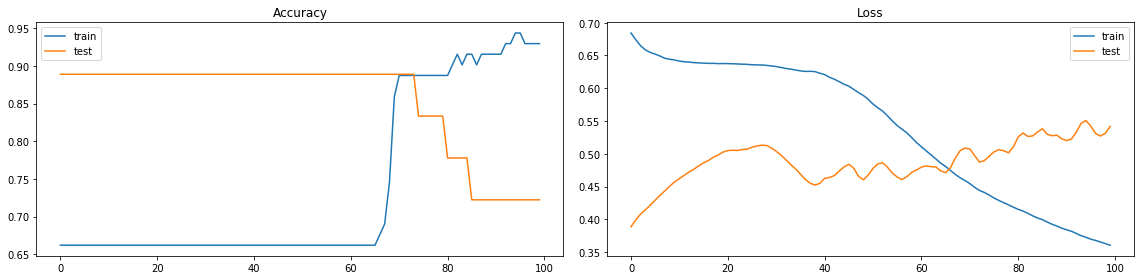

In [0]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.legend(['train','test'])
ax1.set_title('Accuracy')
# -----
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['train','test'])
ax2.set_title('Loss')
# -----
plt.tight_layout()
plt.show()

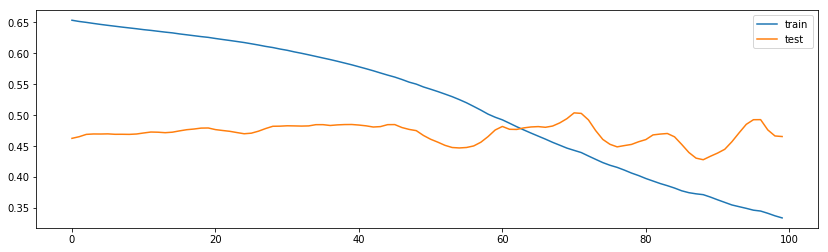

In [0]:
plt.figure(figsize=(14,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'])
plt.show()

## Now try with an autoencoder

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [0]:
n = X_train.shape[1]

# Start with a sequential model
autoencoder = Sequential()
autoencoder.add(Dense(32, input_shape=(n, ), activation="relu"))
autoencoder.add(Dense(n, activation="sigmoid"))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                4256      
_________________________________________________________________
dense_8 (Dense)              (None, 132)               4356      
Total params: 8,612
Trainable params: 8,612
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(autoencoder)

model.add(Dense(16, input_shape=(n,), activation='relu'))
model.add(Dropout(0.10,))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.10,))
model.add(Dense(1, activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Display a summary of your model
# model.summary()

In [0]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=100, verbose=0)

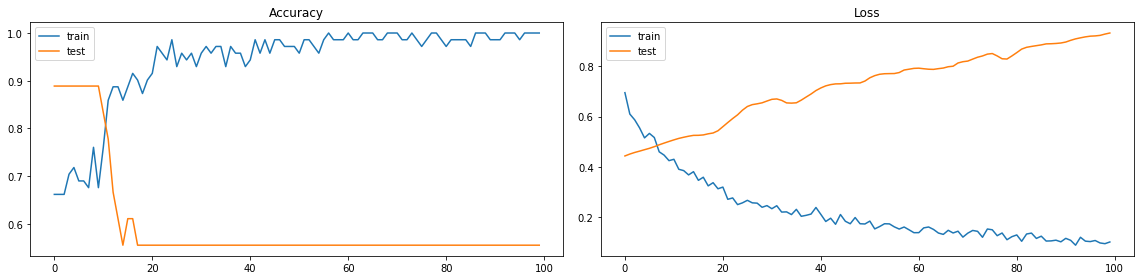

In [0]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.legend(['train','test'])
ax1.set_title('Accuracy')
# -----
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['train','test'])
ax2.set_title('Loss')
# -----
plt.tight_layout()
plt.show()